# Plotting Flux vs. Photon Shooting Using a Moffat PSF

In [2]:
import sys
import os
import math
import logging
import galsim
import matplotlib.pyplot as plt
import numpy as np

## timeit routine to time various different functions

In [11]:
import time
def timeit(func, logger):
    """
    Takes in a function func and runs and times it on the arguments in *args
    Then outputs the output of func(*args) and the time taken.
    """
    def timeit_wrapper(*args, **kwargs):
        tstart = time.time()
        res = func(*args, **kwargs)
        tend = time.time()
        duration = tend-tstart
        return res, duration

    return timeit_wrapper

## Timing Setup

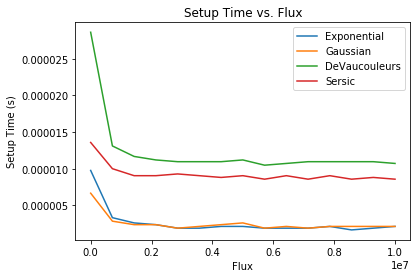

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [12]:
# Initialize the logger
logging.basicConfig(format="%(message)s", level=logging.INFO, stream=sys.stdout)
logger = logging.getLogger("demo7")

random_seed = 1534225

gal_flux = 1.e5 # counts
rng = galsim.BaseDeviate(random_seed + 1)
gal_r0 = 2.7 # arcseconds
psf_beta = 5
pixel_scale = 0.2
psf_re = 1.0 # arcsec

nx = 64
ny = 64

# Obtaining setup start time to obtain fixed costs for setting up 
# a particular type of profile. 

num_gals = 4

# Creates linearly and logarithmically spaced flux values
fluxs = np.linspace(1.e3, 1.e7, 15)
log_fluxs = np.logspace(3, 7, 15)

# Identify the flux scale used
# Uncomment one or the other to use one or the other throughout the code.

flux_scale = fluxs
# flux_scale = log_fluxs

# An array to store fluxs. This array is 15x4, where 15 is the number
# flux values that we are using. There are 4 columns because that is the number of 
# galaxies.
setup_times_vary_flux = np.zeros((num_gals, len(flux_scale)))

# Each index stores the 4 galaxies at different flux indices.
gals_flux = []

for i, gal_flux in enumerate(flux_scale):
    # Storing the setup times for each galaxy

    # Using different galaxy profiles
    gal_exp, time_exp_gal = timeit(galsim.Exponential, logger) (half_light_radius=1, flux=gal_flux)
    gal_gauss, time_gauss_gal = timeit(galsim.Gaussian, logger) (half_light_radius=1, flux=gal_flux)
    gal_devauc, time_devauc_gal = timeit(galsim.DeVaucouleurs, logger) (half_light_radius=1, flux=gal_flux)
    gal_sers, time_sers_gal = timeit(galsim.Sersic, logger) (half_light_radius=1, flux=gal_flux, n=2.5)

    # Store the generated galaxy for each flux value
    gals_flux.append([gal_exp, gal_gauss, gal_devauc, gal_sers])

    # Adding all the times to the setup time list
    setup_times_vary_flux[0, i] = time_exp_gal
    setup_times_vary_flux[1, i] = time_gauss_gal
    setup_times_vary_flux[2, i] = time_devauc_gal
    setup_times_vary_flux[3, i] = time_sers_gal


# Plotting setup times
galaxy_names = ["Exponential", "Gaussian", "DeVaucouleurs", "Sersic"]

# Plotting setup times
plt.title("Setup Time vs. Flux")
plt.xlabel("Flux")
plt.ylabel("Setup Time (s)")
plt.plot(flux_scale, setup_times_vary_flux[0], label=galaxy_names[0])
plt.plot(flux_scale, setup_times_vary_flux[1], label=galaxy_names[1])
plt.plot(flux_scale, setup_times_vary_flux[2], label=galaxy_names[2])
plt.plot(flux_scale, setup_times_vary_flux[3], label=galaxy_names[3])
plt.legend()
plt.show()
plt.figure()

## Timing convolution and Photon shooting

gals_flux_index: 0
gals_flux_index: 1
gals_flux_index: 2
gals_flux_index: 3
gals_flux_index: 4
gals_flux_index: 5
gals_flux_index: 6
gals_flux_index: 7
gals_flux_index: 8
gals_flux_index: 9
gals_flux_index: 10
gals_flux_index: 11
gals_flux_index: 12
gals_flux_index: 13
gals_flux_index: 14


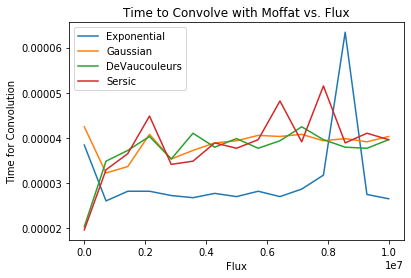

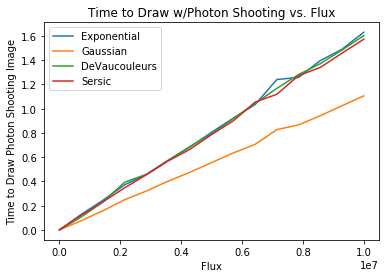

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [13]:
# Define the Moffat PSF
moffat_psf, moffat_psf_time = timeit(galsim.Moffat, logger) (beta=psf_beta, flux=1., half_light_radius=psf_re)

# final profile (these are galsim.Convolution objects)
finals = []

# Stores the time it takes to do a convolution with various galaxies at 
# different fluxs. This is a 15x4 array where at each galaxy generated at a 
# given flux level, we compute the time required to do a convolution with the Moffat PSF.
convolution_times = np.zeros((num_gals, len(flux_scale)))
final_times = np.zeros((num_gals, len(flux_scale)))

# For each kind of galaxy, we time the convolution
for gals_flux_ind, gals in enumerate(gals_flux):
    finals_at_flux = []
    logger.info("gals_flux_index: %d", gals_flux_ind)
    flux_val = flux_scale[gals_flux_ind]
    flux_ind = gals_flux_ind

    for gal_ind, gal in enumerate(gals):

        cnvl_img_final, cnvl_time = timeit(galsim.Convolve, logger)([gal, moffat_psf])
        convolution_times[gal_ind, flux_ind] = cnvl_time
        finals_at_flux.append(cnvl_img_final)

        image = galsim.ImageF(2*nx+2, ny, scale=pixel_scale)
        phot_image = image[galsim.BoundsI(nx+3, 2*nx+2, 1, ny)]

        img, draw_img_time = timeit(cnvl_img_final.drawImage, logger) (phot_image, method="phot", rng=rng)
        final_times[gal_ind, flux_ind] = draw_img_time


# Plotting results...
plt.title("Time to Convolve with Moffat vs. Flux")
plt.xlabel("Flux")
plt.ylabel("Time for Convolution")
plt.plot(flux_scale, convolution_times[0], label=galaxy_names[0])
plt.plot(flux_scale, convolution_times[1], label=galaxy_names[1])
plt.plot(flux_scale, convolution_times[2], label=galaxy_names[2])
plt.plot(flux_scale, convolution_times[3], label=galaxy_names[3])
plt.legend()
plt.show()
plt.figure()

# Obtaining the fixed setup costs for a given type of profile
# Currently, we're only doing Exponential galaxy profiles with Moffat psfs


plt.title("Time to Draw w/Photon Shooting vs. Flux")
plt.xlabel("Flux")
plt.ylabel("Time to Draw Photon Shooting Image")
plt.plot(flux_scale, final_times[0], label=galaxy_names[0])
plt.plot(flux_scale, final_times[1], label=galaxy_names[1])
plt.plot(flux_scale, final_times[2], label=galaxy_names[2])
plt.plot(flux_scale, final_times[3], label=galaxy_names[3])
plt.legend()
plt.show()
plt.figure()